In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import emcee
import torch
import sacc
import corner
import os
import itertools
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
from IPython.display import clear_output

from copy import deepcopy

import src.training as training
import src.models as models

from multiprocessing import Pool, cpu_count
from time import time
from importlib import reload
reload(training)
reload(models)

seed = 14
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# set device for all tensors
device = 'cuda'

# set matplotlib plotting style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

### Define functions to carry out tests

In [2]:
def load_train_test_val(filepath, n_samples, seed=14):
    # test with random samples
    with h5.File(filepath, 'r') as f:
        X = f['hypercube'][:]
        y = f['c_ells'][:]

    # split into test training and validation sets
    # Fix test size so different sampling don't test on different numbers of samples
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=n_samples, test_size=10000, random_state=seed, shuffle=True
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_test, y_test, train_size=4000, test_size=6000, random_state=seed, shuffle=True
    )

    # Take log of y
    y_train = np.log(y_train)
    y_test = np.log(y_test)
    y_val = np.log(y_val)

    # Send data to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

    #Scale the data
    ScalerX = training.TorchStandardScaler()
    X_train = ScalerX.fit_transform(X_train)
    X_test = ScalerX.transform(X_test)
    X_val = ScalerX.transform(X_val)

    ScalerY = training.TorchStandardScaler()
    y_train = ScalerY.fit_transform(y_train)
    y_val = ScalerY.transform(y_val)
        
    train_data = TensorDataset(X_train, y_train)
    
    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=5000, shuffle=False)

    return train_data, test_loader, X_val, y_val, ScalerY

In [3]:
def test_model(model, test_loader, ScalerY, weights=None):
    model.eval()
    y_pred = torch.tensor([]).to(device)
    y_test = torch.tensor([]).to(device)
    for X_batch, y_batch in test_loader:
        model.eval()
        with torch.no_grad(): # don't compute gradients during inference
            y_pred_batch = model(X_batch, params=weights)
            y_pred = torch.cat((y_pred, y_pred_batch), dim=0)
            y_test = torch.cat((y_test, y_batch), dim=0)
    # Inverse transform the data
    y_pred = ScalerY.inverse_transform(y_pred)

    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # Exponentiate the data
    y_pred_np = np.exp(y_pred_np)
    y_test_np = np.exp(y_test_np)

    # Compute mean absolute percentage error along the test set
    apes = np.abs((y_test_np - y_pred_np) / y_test_np) * 100
    ell_ape = np.mean(apes, axis=1)
    maml_mape = np.mean(apes, axis=0)
    maml_frate = len(ell_ape[ell_ape > 5]) / len(ell_ape)

    return maml_mape, maml_frate

In [4]:
def train_fresh_emulator(train_loader, X_val, y_val):

    # Define the model
    model = models.FastWeightCNN(
        input_size=10,
        latent_dim=(16,16),
        output_size=750,
        dropout_rate=0.2
    )
    model.to(device)

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

    # Define the loss function
    loss_fn = torch.nn.MSELoss()

    force_stop = np.inf

    train_losses = []
    val_losses = []
    converged = False
    best_val_loss = np.inf
    strike = 0
    epoch = 0
    start = time()
    while not converged:
        #clear_output(wait=True)
        epoch_loss = 0
        batch_count = 0
        model.train()
        for X_batch, y_batch in train_loader:

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        # Check for convergence
        epoch += 1
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val)
            val_loss = loss_fn(y_pred, y_val).item()
            val_losses.append(val_loss)

        if best_val_loss - val_loss < 1e-4:
            strike += 1
            if strike > 20 or epoch > force_stop:
                converged = True
                print('Validation loss has not improved for 20 epochs. Converged.')
        else:
            strike = 0
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss

        avg_epoch_loss = epoch_loss / batch_count
        train_losses.append(avg_epoch_loss)
        #print(f'Epoch {epoch} - avg loss: {avg_epoch_loss} - Strike: {strike}')
        train_time = time()-start

    return model, train_time

### Load MAML model

In [5]:
# load MAML model
maml_model = models.FastWeightCNN(
    input_size=10,
    latent_dim=(16,16),
    output_size=750,
    dropout_rate=0.2
)

# Create a new MetaLearner instance
metalearner = training.MetaLearner(
    model=maml_model,
    outer_lr=0.01,
    inner_lr=0.001,
    loss_fn=torch.nn.MSELoss,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    seed=14,
    device=device
)

# Load metaleraner weights
metalearner.model.load_state_dict(
    torch.load(
        '{}batch_{}samples_{}tasks_metalearner_weights.pt'.format(5, 1000, 20)
    )
)

/home/b7009348/miniconda3/envs/cosymaml/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


<All keys matched successfully>

In [6]:
print(np.linspace(500, 20000, 40).astype(int))

[  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  6500  7000  7500  8000  8500  9000  9500 10000 10500 11000 11500 12000
 12500 13000 13500 14000 14500 15000 15500 16000 16500 17000 17500 18000
 18500 19000 19500 20000]


### Carry out test for MCMC distribution task

In [ ]:
n_samples = np.linspace(500, 20000, 40).astype(int)
smooth = 20
filepath = 'mcmc_dndz_nsamples=30000.h5'

fresh_times = np.zeros((smooth, len(n_samples)))
fresh_mapes = np.zeros((smooth, len(n_samples)))
fresh_frates = np.zeros((smooth, len(n_samples)))
maml_times = np.zeros((smooth, len(n_samples)))
maml_mapes = np.zeros((smooth, len(n_samples)))
maml_frates = np.zeros((smooth, len(n_samples)))
seeds = np.zeros((smooth, len(n_samples)))

for i, samples in enumerate(n_samples):
    for j in range(smooth):
        clear_output(wait=True)
        print(f'Running {j+1}/{smooth} for {samples} samples')
        seed = np.random.randint(0, 1000)

        # Load the training data
        train_data, test_loader, X_val, y_val, ScalerY = load_train_test(filepath=filepath, n_samples=samples, seed=seed)

        # Train a fresh emulator
        train_loader = DataLoader(train_data, batch_size=5000, shuffle=False)
        fresh_model, fresh_time = train_fresh_emulator(train_loader, X_val, y_val)

        # Sub-select 500 samples from the training set:
        X_train, y_train = train_data[:500]
        start = time()
        task_weights, _ = metalearner.finetune(
            X_train, y_train, adapt_steps=64, use_new_adam=True
        )
        maml_time = time() - start

        # test models on test set
        maml_mape, maml_frate = test_model(maml_model, test_loader, ScalerY, weights=task_weights)
        fresh_mape, fresh_frate = test_model(fresh_model, test_loader, ScalerY)

        # Save results
        fresh_times[j, i] = fresh_time
        fresh_mapes[j, i] = np.mean(fresh_mape)
        fresh_frates[j, i] = fresh_frate
        maml_times[j, i] = maml_time
        maml_mapes[j, i] = np.mean(maml_mape)
        maml_frates[j, i] = maml_frate
        seeds[j, i] = seed

Running 16/20 for 17500 samples


In [ ]:
# Plot ratio of fresh / maml
mape_ratio = np.mean(fresh_mapes, axis=0) / np.mean(maml_mapes, axis=0)
fresh_mape_std = np.std(fresh_mapes, axis=0)
maml_mape_std = np.std(maml_mapes, axis=0)

mape_ratio_std = mape_ratio * np.sqrt((fresh_mape_std / np.mean(fresh_mapes, axis=0))**2 + (maml_mape_std / np.mean(maml_mapes, axis=0))**2)
print(mape_ratio_std.shape)
plt.plot(n_samples, mape_ratio, label='Fresh training / MAML fine-tuning, 64 epochs 500 samples', color='forestgreen')
plt.fill_between(
    n_samples,
    mape_ratio - mape_ratio_std,
    mape_ratio + mape_ratio_std,
    color='forestgreen', alpha=0.3
)
plt.axhline(1, color='k', ls='--')

plt.xlabel(r'Number of training samples')
plt.ylabel(r'Ratio of mean absolute percentage errors, $|\bar{\epsilon}_{Fresh}|/|\bar{\epsilon}_{MAML}|$')

plt.legend()
plt.savefig('maml_vs_fresh_mape_mcmc.pdf', bbox_inches='tight')

In [ ]:
# repeat for frate
c = 'forestgreen'
frate_ratio = np.mean(fresh_frates, axis=0) / np.mean(maml_frates, axis=0)
fresh_frate_std = np.std(fresh_frates, axis=0)
maml_frate_std = np.std(maml_frates, axis=0)

frate_ratio_std = frate_ratio * np.sqrt((fresh_frate_std / np.mean(fresh_frates, axis=0))**2 + (maml_frate_std / np.mean(maml_frates, axis=0))**2)
print(frate_ratio_std.shape)
plt.plot(n_samples, frate_ratio, label='Fresh training / MAML fine-tuning, 64 epochs 500 samples', color=c)
plt.fill_between(
    n_samples,
    frate_ratio - frate_ratio_std,
    frate_ratio + frate_ratio_std,
    color=c, alpha=0.3
)
plt.axhline(1, color='k', ls='--')

plt.xlabel(r'Number of training samples')
plt.ylabel(r'Ratio of failure rates, $f_{5}^{Fresh}/f_{5}^{MAML}$')
plt.savefig('maml_vs_fresh_frate_mcmc.pdf', bbox_inches='tight')

### Carry out test for Mulit-peaked distribution task

In [9]:
n_samples = np.linspace(1000, 20000, 5).astype(int)
smooth = 3 
filepath = 'data/multipeak_dndz_nsamples=30000.h5'

fresh_times = np.zeros((smooth, len(n_samples)))
fresh_mapes = np.zeros((smooth, len(n_samples)))
fresh_frates = np.zeros((smooth, len(n_samples)))
maml_times = np.zeros((smooth, len(n_samples)))
maml_mapes = np.zeros((smooth, len(n_samples)))
maml_frates = np.zeros((smooth, len(n_samples)))
seeds = np.zeros((smooth, len(n_samples)))

for i, samples in enumerate(n_samples):
    for j in range(smooth):
        clear_output(wait=True)
        print(f'Running {j+1}/{smooth} for {samples} samples')
        seed = np.random.randint(0, 1000)

        # Load the training data
        train_data, test_loader, X_val, y_val, ScalerY = load_train_test_val(filepath=filepath, n_samples=samples, seed=seed)

        # Train a fresh emulator
        train_loader = DataLoader(train_data, batch_size=5000, shuffle=False)
        fresh_model, fresh_time = train_fresh_emulator(train_loader, X_val, y_val)

        # Sub-select 500 samples from the training set:
        X_train, y_train = train_data[:1000]
        start = time()
        task_weights, _ = metalearner.finetune(
            X_train, y_train, adapt_steps=64, use_new_adam=True
        )
        maml_time = time() - start

        # test models on test set
        maml_mape, maml_frate = test_model(maml_model, test_loader, ScalerY, weights=task_weights)
        fresh_mape, fresh_frate = test_model(fresh_model, test_loader, ScalerY)

        # Save results
        fresh_times[j, i] = fresh_time
        fresh_mapes[j, i] = np.mean(fresh_mape)
        fresh_frates[j, i] = fresh_frate
        maml_times[j, i] = maml_time
        maml_mapes[j, i] = np.mean(maml_mape)
        maml_frates[j, i] = maml_frate
        seeds[j, i] = seed

Running 3/3 for 20000 samples
Validation loss has not improved for 20 epochs. Converged.


(5,)


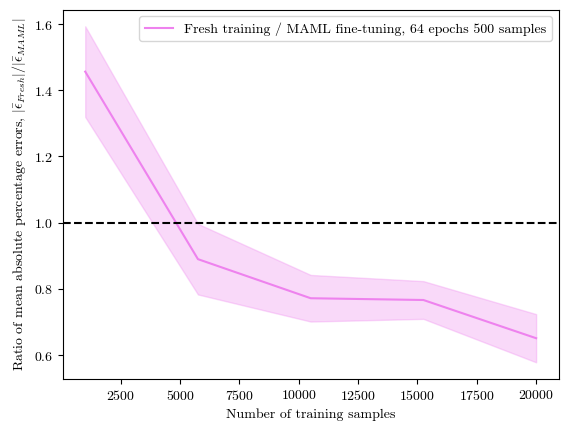

In [10]:
c = 'violet'

# Plot ratio of fresh / maml
mape_ratio = np.mean(fresh_mapes, axis=0) / np.mean(maml_mapes, axis=0)
fresh_mape_std = np.std(fresh_mapes, axis=0)
maml_mape_std = np.std(maml_mapes, axis=0)

mape_ratio_std = mape_ratio * np.sqrt((fresh_mape_std / np.mean(fresh_mapes, axis=0))**2 + (maml_mape_std / np.mean(maml_mapes, axis=0))**2)
print(mape_ratio_std.shape)
plt.plot(n_samples, mape_ratio, label='Fresh training / MAML fine-tuning, 64 epochs 500 samples', color='violet')
plt.fill_between(
    n_samples,
    mape_ratio - mape_ratio_std,
    mape_ratio + mape_ratio_std,
    color='violet', alpha=0.3
)
plt.axhline(1, color='k', ls='--')

plt.xlabel(r'Number of training samples')
plt.ylabel(r'Ratio of mean absolute percentage errors, $|\bar{\epsilon}_{Fresh}|/|\bar{\epsilon}_{MAML}|$')

plt.legend()
plt.savefig('maml_vs_fresh_mape_multi_peak.pdf', bbox_inches='tight')

(10,)


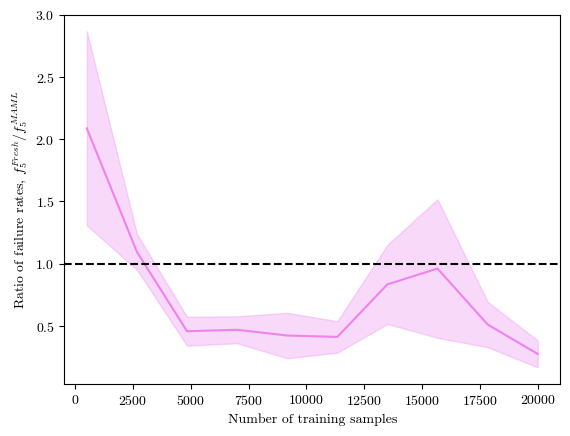

In [ ]:
# repeat for frate
c = 'violet'
frate_ratio = np.mean(fresh_frates, axis=0) / np.mean(maml_frates, axis=0)
fresh_frate_std = np.std(fresh_frates, axis=0)
maml_frate_std = np.std(maml_frates, axis=0)

frate_ratio_std = frate_ratio * np.sqrt((fresh_frate_std / np.mean(fresh_frates, axis=0))**2 + (maml_frate_std / np.mean(maml_frates, axis=0))**2)
print(frate_ratio_std.shape)
plt.plot(n_samples, frate_ratio, label='Fresh training / MAML fine-tuning, 64 epochs 500 samples', color=c)
plt.fill_between(
    n_samples,
    frate_ratio - frate_ratio_std,
    frate_ratio + frate_ratio_std,
    color=c, alpha=0.3
)
plt.axhline(1, color='k', ls='--')

plt.xlabel(r'Number of training samples')
plt.ylabel(r'Ratio of failure rates, $f_{5}^{Fresh}/f_{5}^{MAML}$')
plt.savefig('maml_vs_fresh_frate_multi_peak.pdf', bbox_inches='tight')


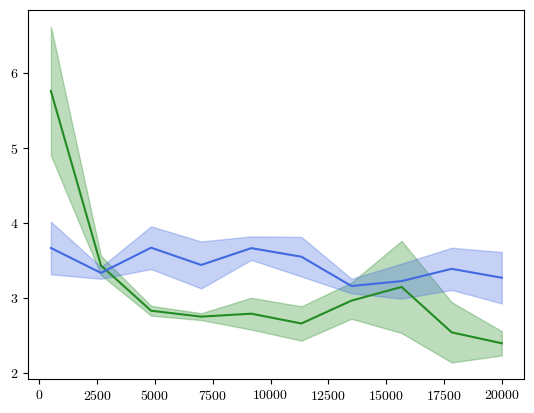

In [ ]:
plt.plot(n_samples, np.mean(fresh_mapes, axis=0), label='Fresh training', color='forestgreen')
plt.fill_between(
    n_samples,
    np.mean(fresh_mapes, axis=0) - np.std(fresh_mapes, axis=0),
    np.mean(fresh_mapes, axis=0) + np.std(fresh_mapes, axis=0),
    color='forestgreen', alpha=0.3
)

plt.plot(n_samples, np.mean(maml_mapes, axis=0), label='MAML fine-tuning', color='royalblue')
plt.fill_between(
    n_samples,
    np.mean(maml_mapes, axis=0) - np.std(maml_mapes, axis=0),
    np.mean(maml_mapes, axis=0) + np.std(maml_mapes, axis=0),
    color='royalblue', alpha=0.3
)